In [7]:
import torch
import mlflow
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from src.sd_vae.ae import VAE
from src.trainers import EarlyStopping
from src.trainers.first_stage_trainer import CLEAR_VAEFirstStageTrainer
from sklearn.manifold import TSNE


from src.utils.exp_utils.train_utils import (
    load_cfg,
    build_first_stage_trainer,
    xavier_init,
)
from src.utils.exp_utils.visual import feature_swapping_plot
from src.utils.data_utils.camelyon import build_dataloader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
dataloaders = build_dataloader(
    data_root="/hpc/group/engelhardlab/ms1008/image_data",
    batch_size=32,
    download=False,
    num_workers=10,
)

In [3]:
train_loader = dataloaders["train"]
valid_loader = dataloaders['valid']

In [4]:
cfg = load_cfg('./config/camelyon.yaml')

In [5]:
cfg

{'mlflow': {'run_name': 'clear-camelyon-0',
  'experiment_name': 'clear-camelyon'},
 'data': {'batch_size': 64,
  'data_root': '/hpc/group/engelhardlab/ms1008/image_data',
  'img_size': 96,
  'name': 'camelyon'},
 'out_dir': './out/camelyon',
 'train': {'early_stopping_patience': 5, 'epochs': 31},
 'trainer_param': {'beta': 0.1,
  'channel_split': [4, 8],
  'contrastive_module': {'contrastive_method': 'SNN',
   'learnable_temp': True,
   'pool': 'gap',
   'temperature': [0.1, 1],
   'use_dense': False,
   'use_proj': True},
  'gamma_c': 1000,
  'gamma_s': 1000,
  'vae_lr': 0.0003},
 'vae': {'channel_multipliers': [1, 2, 4, 4],
  'channels': 32,
  'n_heads': 4,
  'n_resnet_blocks': 2,
  'norm_channels': 32,
  'x_channels': 3,
  'z_channels': 12}}

In [8]:
input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(**cfg['vae']).to(device)

vae.apply(xavier_init)

trainer = CLEAR_VAEFirstStageTrainer(
    model=vae,
    early_stopping=EarlyStopping(patience=8),
    verbose_period=2,
    device=device,
    model_signature=signature,
    args=cfg["trainer_param"],
)

In [26]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test-camelyon")
with mlflow.start_run() as run:
    mlflow.log_params(cfg['vae'] | cfg['trainer_param'])
    trainer.fit(epochs=1, train_loader=train_loader, valid_loader=valid_loader)

100%|██████████| 1091/1091 [00:57<00:00, 19.12batch/s]


epoch 0/val_rec: 345.0152
[INFO]: track model state
[INFO]: log best model


In [9]:
# run_id = run.info.run_id
# print(run_id)
run_id = 'f866c20fc68b4cdab333f1350a41c4fc'

In [ ]:
x = next(iter(dataloaders["train"]))["image"].to(device)
best_model = mlflow.pytorch.load_model(f"runs:/{run_id}/best_model")
with torch.no_grad():
    best_model.eval()
    _, posterior = best_model(x)
z_c, z_s = posterior.mu.split_with_sizes(
    cfg["trainer_param"]["channel_split"], dim=1
)
select = torch.randint(0, 32, (5,)).tolist()

In [16]:
z_c.shape

torch.Size([32, 4, 12, 12])

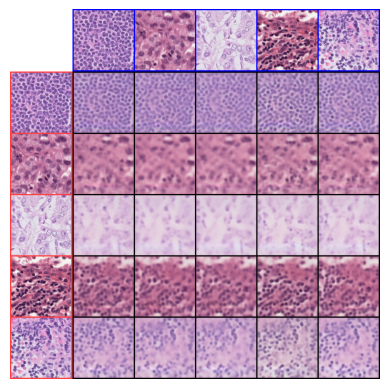

In [17]:
feature_swapping_plot(
    z_c[select],
    z_s[select],
    x[select],
    best_model,
    img_size=96,
)